# Part-01A: Splitting Large Raw Amazon Reviews & Metadata

## Introduction
In any data analysis project, especially those involving large datasets, it is crucial to preprocess and manage the data effectively to ensure meaningful and efficient analysis. This notebook focuses on preparing the Amazon Grocery and Gourmet Food reviews dataset by splitting the large raw data into manageable subsets.

#### Objectives

1. **Load and Combine Data**:
   - Efficiently load the raw review files and metadata.
   - Combine the review and metadata files to create a unified dataset for analysis.

2. **Data Preprocessing**:
   - Filter the metadata to retain only relevant products.
   - Apply one-hot encoding to the categorical data.
   - Remove non-essential features to streamline the dataset.

3. **Create Meaningful Subsets**:
   - Identify products with a significant number of both positive and negative reviews.
   - Group reviews by product, brand, and category to focus the analysis on products with diverse customer feedback.
   - Save the final subsets for detailed analysis in subsequent steps.

By the end of this notebook, we will have a well-structured subset of the Amazon reviews dataset, ready for in-depth analysis to extract valuable insights into customer preferences and sentiments.


In [33]:
## Load in Amazon Reviews Information
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [34]:
import pandas as pd
import os, json, gzip
from urllib.request import urlopen
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth', 200)

## Amazon Dataset Processing

### Load in Filepaths Config Json

In [35]:
import json
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)
FPATHS.keys()

dict_keys(['data', 'images', 'metadata', 'eda', 'models', 'results', 'readme'])

In [36]:
FPATHS['data'].keys()

dict_keys(['s3', 'raw', 'cleaned', 'subset', 'processed-nlp', 'app', 'ml-nlp', 'nn-nlp'])

In [37]:
FPATHS['data']['s3']

{'bucket': 'amazon-reviews-project',
 'metadata': 'amazon-reviews-project/meta_Grocery_and_Gourmet_Food.json.gz',
 'reviews': 'amazon-reviews-project/Grocery_and_Gourmet_Food_5.json.gz'}

In [38]:
FPATHS['data']['raw']

{'large-metadata': 'data/raw/meta_Grocery_and_Gourmet_Food.json.gz',
 'large-reviews': 'data/raw/Grocery_and_Gourmet_Food.json.gz',
 'split-metadata_dict': {'dir': 'data/raw-split/',
  'glob': 'data/raw-split/*meta*part*'},
 'split-reviews_dict': {'dir': 'data/raw-split/',
  'glob': 'data/raw-split/*review*part*'}}

In [39]:
import glob

# json_files = sorted(glob.glob("raw/*.json.gz"))
# json_files

In [40]:
# Testing f-strings for filepath suffix
part=1
print(f"{part:03d}")

001


In [41]:
# !pip install -U boto3
import boto3
s3 = boto3.client('s3')

response = s3.list_buckets()

print("S3 Buckets:")
for bucket in response['Buckets']:
    print(f"  - {bucket['Name']}")




S3 Buckets:
  - amazon-reviews-project


In [42]:
# List all object sin bucket
bucket_name = FPATHS['data']['s3']['bucket']
print(f"{bucket_name=}")

response = s3.list_objects_v2(Bucket=bucket_name)

print("Objects in bucket:")
if 'Contents' in response:
    for obj in response['Contents']:
        print(f"  - {obj['Key']}")
else:
    print("  - Bucket is empty")


bucket_name='amazon-reviews-project'
Objects in bucket:
  - Grocery_and_Gourmet_Food_5.json.gz
  - meta_Grocery_and_Gourmet_Food.json.gz


In [43]:
FPATHS['data']['s3']

{'bucket': 'amazon-reviews-project',
 'metadata': 'amazon-reviews-project/meta_Grocery_and_Gourmet_Food.json.gz',
 'reviews': 'amazon-reviews-project/Grocery_and_Gourmet_Food_5.json.gz'}

In [44]:
# help(s3.download_file)

In [45]:
## Extract required filepaths from json 
# Reviews
review_folder = FPATHS['data']['raw']['split-reviews_dict']['dir']
print(review_folder)
fpath_reviews = FPATHS['data']['raw']['large-reviews']
print(fpath_reviews)

# Metadata
meta_folder  = FPATHS['data']['raw']['split-reviews_dict']['dir']
print(meta_folder)
fpath_meta = FPATHS['data']['raw']['large-metadata']
print(fpath_meta)

# Making new folder for processed reviews
# folder = "raw-split/"
# os.makedirs(folder, exist_ok=True)

data/raw-split/
data/raw/Grocery_and_Gourmet_Food.json.gz
data/raw-split/
data/raw/meta_Grocery_and_Gourmet_Food.json.gz


In [46]:
s3_fpath_reviews = FPATHS['data']['s3']['reviews'].replace("amazon-reviews-project/","")
s3_fpath_meta = FPATHS['data']['s3']['metadata'].replace("amazon-reviews-project/","")
s3_fpath_reviews

'Grocery_and_Gourmet_Food_5.json.gz'

In [47]:

# Download the reviews file
s3.download_file(bucket_name, s3_fpath_reviews , fpath_reviews)
s3.download_file(bucket_name, s3_fpath_meta , fpath_meta)

### Process Raw Poorly Formatted Revies .json.gz

In [48]:
# Set generic folder and fname variables to review versions
folder = review_folder
fname = fpath_reviews

In [49]:
%%time
## Adapted from Source: [parse_and_clean_metadata.ipynb](https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV?usp=sharing)
bad_data = {}

# for fname in files_to_process:
# fname = 'raw/Grocery_and_Gourmet_Food.json.gz'##_5.json.gz'
category = os.path.basename(fname).replace("_5","").replace(".json.gz",'') 

### load the meta data
data = []
review_files_created = []
i = 0 # Counter for row # 
part = 1 # Label for saving data mid-loop
print(f'\n[i] Processing {fname}')

with gzip.open(fname) as f:

    for l in tqdm(f):
        data.append(json.loads(l.strip()))
        i+=1
        # Spliting into smaller csvs
        # every 500,000 reviews, save new csv.gz
        if i > 100_000:
            try:
                df = pd.DataFrame(data)
                # df = df.fillna('')
                # filter_title = df['title'].str.contains('getTime')
                # df = df[~filter_title] 
                fname_csv =f"{folder}amazon-reviews-{category.lower().strip()}-part-{part:03d}.csv"#.gz" 
                
                print(f"- Creating file: {fname_csv}")
                df.to_csv(fname_csv, index=False)#, compression='gzip')
                review_files_created.append(fname_csv)
                
            except Exception as e:
                print("Error with ")
                bad_data[fname] = data.copy()
                display(e)
                print(e)
            
            finally:
                # Increment file part number and reset i 
                part+=1
                i = 0
                data = []
    
# total length of list, this number equals total number of products
# print(len(data))
print(f'- finished.')
print(f"Errors with files: {bad_data.keys()}")


[i] Processing data/raw/Grocery_and_Gourmet_Food.json.gz


0it [00:00, ?it/s]

- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-001.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-002.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-003.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-004.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-005.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-006.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-007.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-008.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-009.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-010.csv
- Creating file: data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-011.csv
- finished.
Errors with files: dict_keys([])
CPU times: user 14.6

In [50]:
len(bad_data)

0

In [51]:
# Review created files
len(review_files_created)

11

## Preparing Metadata 

In [52]:
# Set generic folder and fname variables to review versions
folder = meta_folder
fname = fpath_meta
fname

'data/raw/meta_Grocery_and_Gourmet_Food.json.gz'

In [53]:
%%time
meta_files_created = []

### load the meta data
metadata = []
i = 0 # Counter for row # 
part = 1 # Label for saving data mid-loop
print(f'\n[i] Processing {fname}')
# os.makedirs(f"{folder}meta/", exist_ok=True)

with gzip.open(fname) as f:
    category = os.path.basename(fname).replace(".json.gz",'').replace("meta_",'')
    
    for l in tqdm(f):
        metadata.append(json.loads(l.strip()))
        i+=1
        # every 200,000 products, save new csv.gz
        if i > 50_000:
            try:
                meta_df = pd.DataFrame(metadata)
                # df = df.fillna('')
                # filter_title = df['title'].str.contains('getTime')
                # df = df[~filter_title]
                
                fname_out = f"{folder}metadata-amazon-{category.lower().strip()}-part-{part:03d}.csv"#.gz"
                print(f"- Creating file {fname_out}")
                meta_df.to_csv(fname_out, 
                          index=False,# compression='gzip', 
                               escapechar="\\")
                meta_files_created.append(fname_out)
            except Exception as e:
                # print("Error with ")
                display(e)
                print(e)
            
            finally:
                # Increment file part number and reset i 
                part+=1
                i = 0
                metadata = []
# meta_files_created


[i] Processing data/raw/meta_Grocery_and_Gourmet_Food.json.gz


0it [00:00, ?it/s]

- Creating file data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-001.csv
- Creating file data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-002.csv
- Creating file data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-003.csv
- Creating file data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-004.csv
- Creating file data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-005.csv
CPU times: user 14.4 s, sys: 695 ms, total: 15.1 s
Wall time: 15.5 s


In [69]:
len(meta_files_created)

5

# 👉Entry Point: Load in Split Files

In [70]:
import glob, os, json
import pandas as pd

In [71]:
import json
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)
FPATHS.keys()

dict_keys(['data', 'images', 'metadata', 'eda', 'models', 'results', 'readme'])

In [72]:
# Get list of metadata files using glob query saved in config 
q = FPATHS['data']['raw']['split-metadata_dict']['glob']
meta_files = sorted(glob.glob(q))
meta_files

['data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-001.csv',
 'data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-002.csv',
 'data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-003.csv',
 'data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-004.csv',
 'data/raw-split/metadata-amazon-grocery_and_gourmet_food-part-005.csv']

In [73]:
# meta_df = pd.concat([pd.read_csv(f) for f in files_created])
meta_df = pd.concat([pd.read_csv(f, low_memory=False) for f in meta_files])
meta_df = meta_df.reset_index(drop=True)
meta_df

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']",NaN,"['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",NaN,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],NaN,Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,NaN,NaN,$41.91,0681727810,[],[],NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']",NaN,"['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",NaN,Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,NaN,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN
2,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",NaN,['Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your conv...,NaN,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],NaN,Unik Occasions,[],"['>#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",['B07DXN65TF'],Amazon Home,NaN,"September 21, 2010",$29.95,1888861118,[],[],NaN
3,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",NaN,"['Large Letter - Height 4.75""']",NaN,Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],NaN,Other,"['Large Letter - Height 4.75""']","['>#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,NaN,"September 11, 2011",$11.45,1888861517,[],[],NaN
4,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",NaN,"['4.75""']",NaN,Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],NaN,Unik Occasions,"['4.75"" height']","['>#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,NaN,"September 11, 2011",$15.00,1888861614,[],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250000,"['Grocery & Gourmet Food', 'Olives, Pickles & Relishes', 'Pickles']",NaN,"['YANKEETRADERS, Pickled Asparagus is a natural asparagus made with just the right combination of dill and other seasonings. Try just one bite of our Pickled Dill Asparagus spears and you will sur...",NaN,"YANKEETRADERS Brand, Fresh Pickled Asparagus (2 Pack)",[],NaN,YANKEETRADERS,[],"399,528 in Grocery & Gourmet Food (",[],Grocery,NaN,NaN,NaN,B010R3NA0G,[],[],"{'Shipping Weight:': '3.4 pounds', 'ASIN: ': 'B010R3NA0G', 'UPC:': '673166005969'}"
250001,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals']",NaN,"['Brown Rice Is Richly Nutritious And Na

<Axes: >

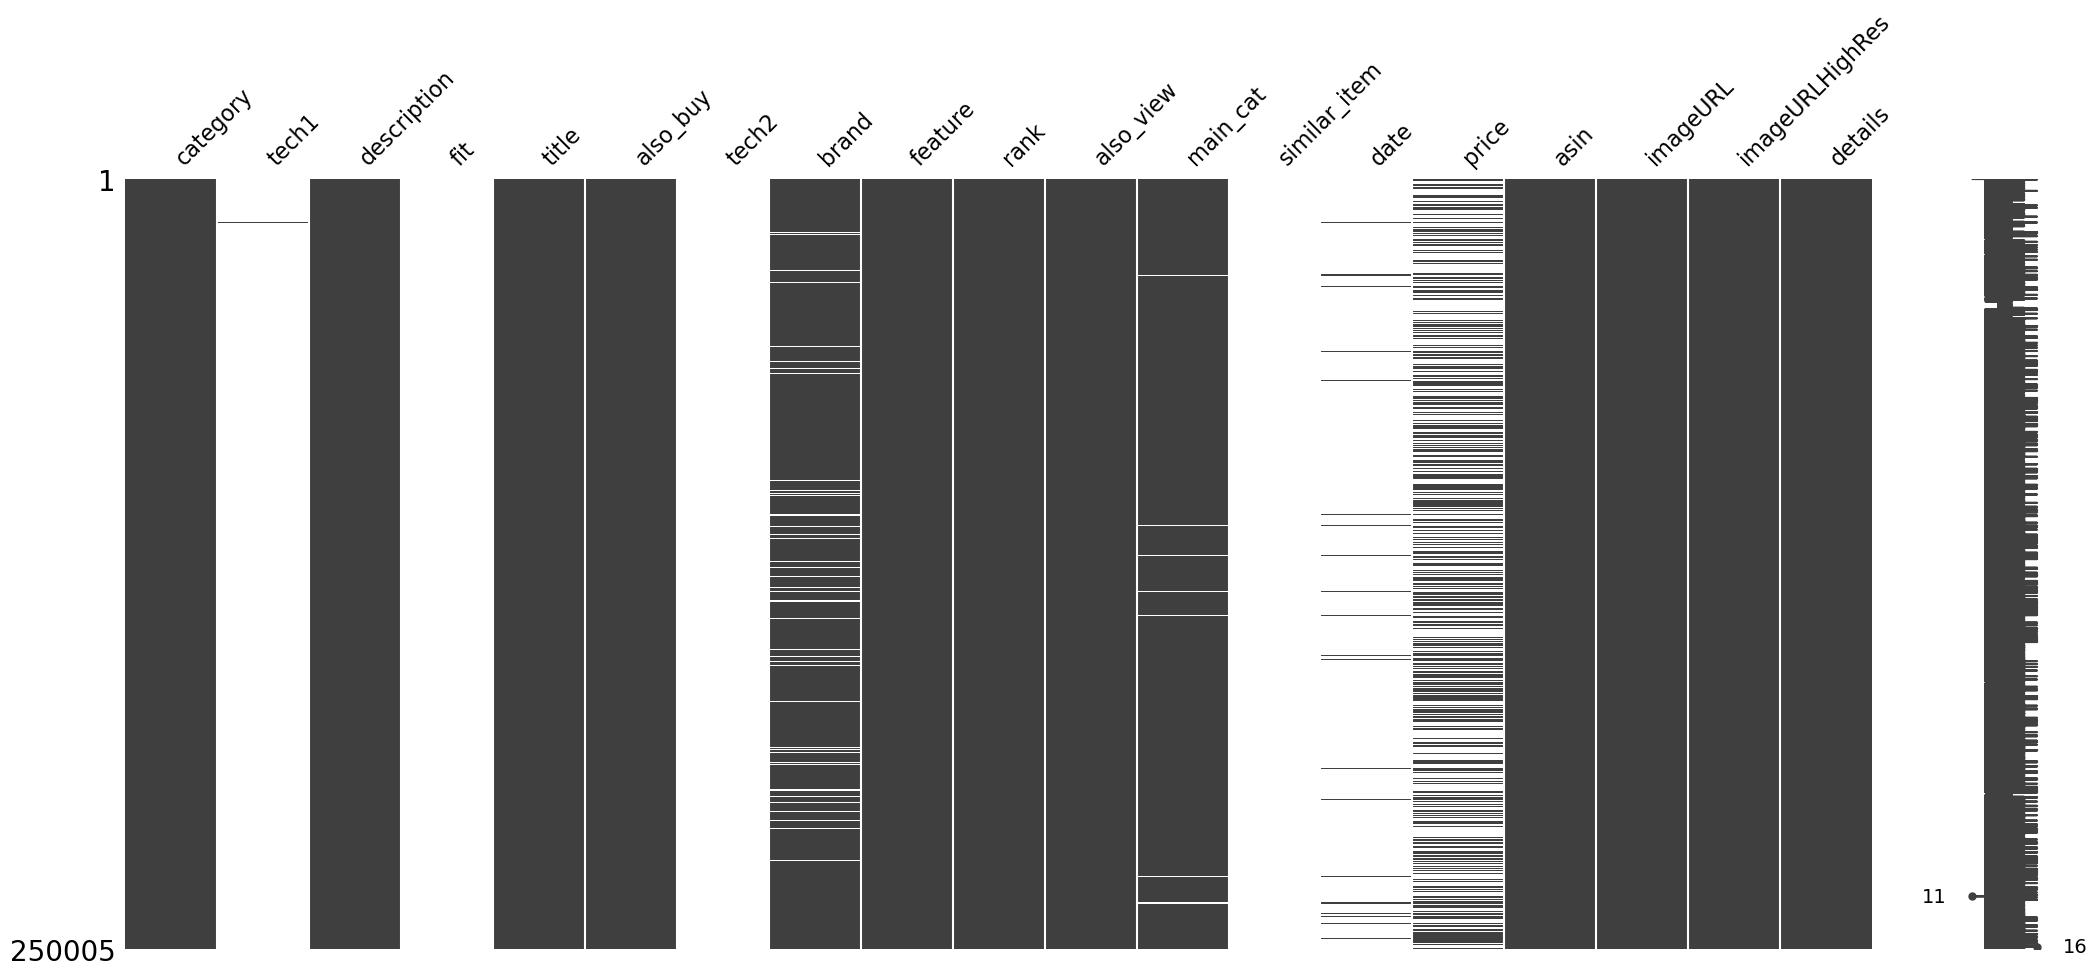

In [74]:
import missingno 
missingno.matrix(meta_df)

In [75]:
# removing columns that are most null
perc_null = meta_df.isna().sum()/len(meta_df) * 100
perc_null

category             0.000000
tech1               99.743205
description          0.000000
fit                 99.998800
title                0.001200
also_buy             0.000000
tech2              100.000000
brand                4.241115
feature              0.000000
rank                 0.000000
also_view            0.000000
main_cat             0.450791
similar_item        99.911202
date                96.919262
price               54.156517
asin                 0.000000
imageURL             0.000000
imageURLHighRes      0.000000
details              0.009600
dtype: float64

In [76]:
# Identifying cols with >95% null
perc_null[perc_null>95]

tech1            99.743205
fit              99.998800
tech2           100.000000
similar_item     99.911202
date             96.919262
dtype: float64

In [77]:
# List of column names to drop
drop_cols = perc_null[perc_null>95].index.tolist()
drop_cols

['tech1', 'fit', 'tech2', 'similar_item', 'date']

In [78]:
# Drop null columns.
meta_df = meta_df.drop(columns=drop_cols, errors='ignore')
meta_df

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN
2,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",['Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your conv...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,[],"['>#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",['B07DXN65TF'],Amazon Home,$29.95,1888861118,[],[],NaN
3,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['Large Letter - Height 4.75""']",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Other,"['Large Letter - Height 4.75""']","['>#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$11.45,1888861517,[],[],NaN
4,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['4.75""']",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,"['4.75"" height']","['>#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$15.00,1888861614,[],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250000,"['Grocery & Gourmet Food', 'Olives, Pickles & Relishes', 'Pickles']","['YANKEETRADERS, Pickled Asparagus is a natural asparagus made with just the right combination of dill and other seasonings. Try just one bite of our Pickled Dill Asparagus spears and you will sur...","YANKEETRADERS Brand, Fresh Pickled Asparagus (2 Pack)",[],YANKEETRADERS,[],"399,528 in Grocery & Gourmet Food (",[],Grocery,NaN,B010R3NA0G,[],[],"{'Shipping Weight:': '3.4 pounds', 'ASIN: ': 'B010R3NA0G', 'UPC:': '673166005969'}"
250001,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals']","['Brown Rice Is Richly Nutritious And Naturally Gluten-free. Grown Without Chemicals, Or Animal-based Fertilizers Of Any Kind, Then Sprouted To Maximize Nutrition, Digestibility And Flavor.', ""'OR...","One Degree Organic Gluten-Free Sprouted Brown Rice Flour, 24 Ounce

## Select Main Category

- Cleaning the categories of html tags

In [79]:
filter_html = meta_df['main_cat'].fillna('').str.contains('<')
filter_html.sum()

103

In [80]:
# filter_html = meta_df['category'].fillna('').str.contains('<')
# filter_html.sum()

In [81]:
# Demonstrating some of the categories with html tags
meta_df[filter_html]

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details
8523,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Pudding & Gelatin', 'Pudding']",['Jell-O Cook & Serve Banana Cream Pudding (3 oz.)'],Jell-O Pudding &amp; Pie Filling Banana Cream Cook &amp; Serve - 24 Pack,[],NaN,[],"1,905,637 in CDs & Vinyl (",['B00JD9WTLM'],"<img src=""https://images-na.ssl-images-amazon.com/images/G/01/digital/music/logos/amzn_music_logo_subnav._CB471835632_.png"" class=""nav-categ-image"" alt=""Digital Music""/>",NaN,B0007OXDOO,[],[],{'ASIN:': 'B0007OXDOO'}
9348,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations']",[],Kids Picks Hit Mix 4,[],Various Artists,[],"679,355 in CDs & Vinyl (",[],"<img src=""https://images-na.ssl-images-amazon.com/images/G/01/digital/music/logos/amzn_music_logo_subnav._CB471835632_.png"" class=""nav-categ-image"" alt=""Digital Music""/>",$1.94,B000A7Q2J6,[],[],"{'Audio CD': '(August 16, 2005)', 'Number of Discs:': '1', 'Label:': 'Capitol', 'ASIN:': 'B000A7Q2J6'}"
19786,"['Grocery & Gourmet Food', 'Cooking & Baking']",['Greek Fisherman/Sailor Hat Black Wool Choose a SizeFor a classic accessory that looks great both on and off the water choose aGreek fishermans hat. Made of black wool this traditional Greek fish...,Greek Fisherman Hat Black Wool (Choose a Size) Size 7,[],Parthenon Foods,[],"1,089,878 in Grocery & Gourmet Food (",[],"<img src=""https://images-na.ssl-images-amazon.com/images/G/01/nav2/images/gui/amazon-fashion-store-new._CB520838675_.png"" class=""nav-categ-image"" alt=""AMAZON FASHION""/>",$25.29,B000LRH8XY,[],[],"{'\\n Item Weight: \\n ': '6.4 ounces', 'Shipping Weight:': '6.4 ounces (', 'ASIN: ': 'B000LRH8XY', 'UPC:': '847126168616'}"
23793,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Milk & Cream', 'Dairy Milk']","['Native Forest Unsweetened Classic Coconut Milk, Organic, 13.5 Fl Oz', 'Once opened, refrigerate and enjoy within 4 days.', 'Organic coconut milk (organic coconut, water, organic guar gum).', 'Co...","Native Forest Unsweetened Classic Coconut Milk, Organic, 13.5 Fl Oz","['B000VK3RLS', 'B000QX94JE']",Native Forest,[],[],"['B00M8VSKW4', 'B011LVDECM', 'B001HTJ2BQ', 'B01MA4GQH9', 'B00AF7XMYY', 'B000VDZ3VW', 'B074RPKLCK', 'B077XW2LKS', 'B00CQ7RYZ4', 'B000VK3RLS', 'B0047YYY98', 'B00JUB8N3G', 'B00113ZZ5U', 'B001HTJ2ES',...","<img src=""https://images-na.ssl-images-amazon.com/images/G/01/pantry/subnav/pantry-subnav-logo._CB474181323_.png"" class=""nav-categ-image"" alt=""Prime Pantry""/>",NaN,B000QSOC4Q,"['https://images-na.ssl-images-amazon.com/images/I/312uJMe8ZoL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/616Dvls7naL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.com/images/I/312uJMe8ZoL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/616Dvls7naL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51l9zsMCp...","{'\\n Product Dimensions: \\n ': '2.9 x 2.8 x 4.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.1 pounds', 'Domestic Shipping: ': 'Item can be shipped within U.S.', 'International Shipping: ..."
27250,"['Grocery & Gourmet Food', 'Cooking & Baking']",['Made in Greece. Stock may be light or dark blue.'],Worry Beads - Komboloi Blue with Silver,[],Parthenon Foods,"['<span class=""a-text-bold"">Shipping Weight:\\n </span>\\n <span>1.6 ounces (<a href=\\'https://www.amazon.com/gp/help/seller/shipping.html/ref=dp_pd_shipping...","517,369 in Grocery & Gourmet Food (","['B00IOWPROU', 'B00O976SDI', 'B076LPPWVS', 'B00K4AK0JM', 'B0723616PL', 'B07CXJ5DYL', 'B07CVLDH2Y', 'B077M56Y3J']","<img src=""https://images-na.ssl-images-amazon.com/images/G/01/nav2/images/gui/amazon-fashion-store-new._CB520838675_.png"" class=""nav-categ-image"" alt=""AMAZON FASHION""/>",$8.04,B000VA5IZQ,[],[],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245521,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Coffe

In [82]:
# import re

# # Regular expression to match HTML tags
# regex = r"<[^>]*>"


# # Apply the regex to the DataFrame column using str.replace
# meta_df['main_cat-cleaned'] = meta_df['main_cat'].str.replace(regex, '', regex=True)
# # meta_df['category-cleaned'] = meta_df['category'].str.replace(regex, '', regex=True)
# meta_df.loc[filter_html, ['main_cat']].head().values

- The categories with html tags are not relevant so we can drop

In [83]:
# Removing products with bad main category
meta_df = meta_df.loc[~filter_html]
meta_df = meta_df.reset_index(drop=True)
# meta_df = meta_df.set_index('asin')
meta_df

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN
2,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",['Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your conv...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,[],"['>#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",['B07DXN65TF'],Amazon Home,$29.95,1888861118,[],[],NaN
3,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['Large Letter - Height 4.75""']",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Other,"['Large Letter - Height 4.75""']","['>#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$11.45,1888861517,[],[],NaN
4,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['4.75""']",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,"['4.75"" height']","['>#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$15.00,1888861614,[],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249897,"['Grocery & Gourmet Food', 'Olives, Pickles & Relishes', 'Pickles']","['YANKEETRADERS, Pickled Asparagus is a natural asparagus made with just the right combination of dill and other seasonings. Try just one bite of our Pickled Dill Asparagus spears and you will sur...","YANKEETRADERS Brand, Fresh Pickled Asparagus (2 Pack)",[],YANKEETRADERS,[],"399,528 in Grocery & Gourmet Food (",[],Grocery,NaN,B010R3NA0G,[],[],"{'Shipping Weight:': '3.4 pounds', 'ASIN: ': 'B010R3NA0G', 'UPC:': '673166005969'}"
249898,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals']","['Brown Rice Is Richly Nutritious And Naturally Gluten-free. Grown Without Chemicals, Or Animal-based Fertilizers Of Any Kind, Then Sprouted To Maximize Nutrition, Digestibility And Flavor.', ""'OR...","One Degree Organic Gluten-Free Sprouted Brown Rice Flour, 24 Ounce

In [84]:
meta_df.duplicated().sum()

3697

In [85]:
meta_df = meta_df.drop_duplicates()
meta_df

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN
2,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",['Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your conv...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,[],"['>#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",['B07DXN65TF'],Amazon Home,$29.95,1888861118,[],[],NaN
3,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['Large Letter - Height 4.75""']",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Other,"['Large Letter - Height 4.75""']","['>#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$11.45,1888861517,[],[],NaN
4,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['4.75""']",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,"['4.75"" height']","['>#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$15.00,1888861614,[],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249897,"['Grocery & Gourmet Food', 'Olives, Pickles & Relishes', 'Pickles']","['YANKEETRADERS, Pickled Asparagus is a natural asparagus made with just the right combination of dill and other seasonings. Try just one bite of our Pickled Dill Asparagus spears and you will sur...","YANKEETRADERS Brand, Fresh Pickled Asparagus (2 Pack)",[],YANKEETRADERS,[],"399,528 in Grocery & Gourmet Food (",[],Grocery,NaN,B010R3NA0G,[],[],"{'Shipping Weight:': '3.4 pounds', 'ASIN: ': 'B010R3NA0G', 'UPC:': '673166005969'}"
249898,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals']","['Brown Rice Is Richly Nutritious And Naturally Gluten-free. Grown Without Chemicals, Or Animal-based Fertilizers Of Any Kind, Then Sprouted To Maximize Nutrition, Digestibility And Flavor.', ""'OR...","One Degree Organic Gluten-Free Sprouted Brown Rice Flour, 24 Ounce

In [86]:
len(meta_df)

246205

In [87]:
# fpath_meta = "combined-metadata-amazon-groceries-gourmet.csv.gz"
# meta_df.to_csv(fpath_meta,compression='gzip', index=False)
# # meta_df.to_json(fpath_meta)

In [88]:
# meta_df.loc[filter_html, ['main_cat']].value_counts()

### Saving Product Asin Map

In [89]:
# raise Exception("Review your workflow from the codealong repo before continuing below")

In [90]:
meta_df.head()

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN
2,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']",['Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your conv...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,[],"['>#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",['B07DXN65TF'],Amazon Home,$29.95,1888861118,[],[],NaN
3,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['Large Letter - Height 4.75""']",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Other,"['Large Letter - Height 4.75""']","['>#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$11.45,1888861517,[],[],NaN
4,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']","['4.75""']",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,[],Unik Occasions,"['4.75"" height']","['>#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)', '>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers']",[],Amazon Home,$15.00,1888861614,[],[],NaN


In [91]:
meta_df.duplicated().sum()

0

In [92]:
# Saving map of asin to title and brand
id_cols = ['asin','title','brand']
meta_df.duplicated(subset=id_cols).sum()

0

In [93]:
# Saving map of asin to title and brand
asin_meta_df = meta_df[id_cols].copy().set_index('asin')
asin_meta_df

,title,brand
asin,,
0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports
0853347867,Trim Healthy Mama Xylitol,NaN
1888861118,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions
1888861517,Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other
1888861614,Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions
...,...,...
B010R3NA0G,"YANKEETRADERS Brand, Fresh Pickled Asparagus (2 Pack)",YANKEETRADERS
B010R4B8OU,"One Degree Organic Gluten-Free Sprouted Brown Rice Flour, 24 Ounce - 6 per case.",One Degree Organic Foods
B010R544D6,"Hershey's Milk Chocolate Covered Almond Eggs, 9.10 Ounce Bag (Pack of 4)",HERSHEY'S


In [94]:
asin_title_map = asin_meta_df.to_dict(orient='index')
# asin_title_map = asin_meta_df.to_json()
asin_title_map['0681727810']

{'title': 'Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs',
 'brand': 'Ariola Imports'}

In [95]:
# # Get dict map of asin id to title 
# asin_title_map = meta_df.set_index('asin')['title'].to_dict()
# list(asin_title_map.keys())[:5]

In [96]:
# # Make a new folder for metadata
fpath_asin_map = FPATHS['data']['cleaned']['asin-id-title-dict_json']
print(fpath_asin_map)
with open(fpath_asin_map,'w') as f:
    json.dump(fpath_asin_map,f)

data/metadata/amazon-groceries-asin-titles-lookup.json


In [97]:
# pd.read_json('data/metadata/amazon-groceries-asin-titles-lookup.json')

In [98]:
with open(fpath_asin_map,'r') as f:
    test = json.load(f)
test

'data/metadata/amazon-groceries-asin-titles-lookup.json'

## Filter for Correct Main Category

In [99]:
# meta_df['title'].str.contains("Barbie").sum()

In [100]:
meta_df['main_cat'].value_counts()

main_cat
Grocery                         225382
Health & Personal Care            7507
Amazon Home                       6930
Toys & Games                      1533
All Beauty                        1326
Industrial & Scientific            933
Office Products                    527
Sports & Outdoors                  347
Cell Phones & Accessories          145
Pet Supplies                       116
Arts, Crafts & Sewing              115
Baby                                72
Tools & Home Improvement            57
Computers                           37
All Electronics                     18
Home Audio & Theater                12
Automotive                           6
Movies & TV                          4
Musical Instruments                  3
Software                             2
Camera & Photo                       2
Video Games                          2
Portable Audio & Accessories         1
Car Electronics                      1
Name: count, dtype: int64

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_85905/2139762053.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['category_list'] = meta_df['category'].map(ast.literal_eval)


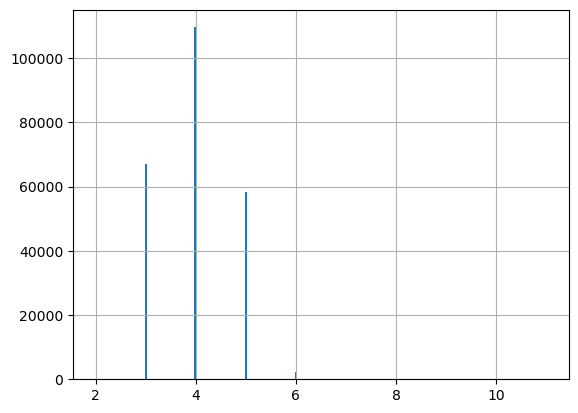

In [101]:
import ast 

meta_df['category_list'] = meta_df['category'].map(ast.literal_eval)
meta_df['category_list'].map(len).hist(bins='auto');

In [102]:
## TEMP TEST IF USING MAIN_CAT ALONE IS SUFFICIENT
filter_main_cat = meta_df['main_cat'] == "Grocery"
meta_df = meta_df[filter_main_cat]
meta_df

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details,category_list
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]"
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]"
10,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Label Tea (loose tea) - 450g,"['B00886E4K0', 'B00CREXSHY', 'B001QTRGAQ', 'B002EYZM4O', 'B000JSQK70', 'B00FMTETUQ', 'B001VIIXXQ', 'B002UP153Y', 'B07DZ4M75Z', 'B00N48M0OO', 'B000JSQDK4', 'B000JSQDGS', 'B00NMV6Y4A', 'B01HIKU16M',...",Lipton,[],"30,937 in Grocery & Gourmet Food (","['B00CREXSHY', 'B001QTRGAQ', 'B000JSQK70', 'B002EYZM4O', 'B01282ULWY', 'B000JSQDGS', 'B00886E4K0', 'B002YJC990', 'B000JSQDK4', 'B001VIIXXQ', '4639725183', 'B007ZI1SKG', 'B002UP153Y', 'B007ZI1UFY',...",Grocery,$12.46,4639725043,"['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21kL85tr1...",NaN,"[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Black]"
11,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Teabags uses a new way to make tea. To lock in as much of the tea taste and aroma as possible, we developed an innovative new process. We press fresh, high quality tea leaves...",Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),"['B000JSQDK4', 'B007ZI1SKG', '4639725043', 'B00KPFHOPO', 'B01LY2304D', 'B00GRS0CAM', 'B00RZ7EOC6', 'B007SH2C6S', 'B000MQ5YRQ', 'B00286KM8E', 'B0005XMOI8', 'B000GG5IYQ', 'B009UQXD90', 'B00BOMGIBI']",Lipton,[],"15,487 in Grocery & Gourmet Food (","['B000JSQDK4', 'B007ZI1SKG', 'B00286KM8E', 'B01LY2304D', '4639725043', 'B00BOMGIBI', 'B00CISKNPO', 'B00U9W37QS', 'B003CJJLYW', 'B00KO3O1BC', 'B002YJC990', 'B003CJLNT8', 'B000MQ5YRQ', 'B007ZI1UFY',...",Grocery,$12.98,4639725183,['https://images-na.ssl-images-amazon.com/images/I/31TlgFpkgZL._SS40_.jpg'],['https://images-na.ssl-images-amazon.com/images/I/31TlgFpkgZL.jpg'],NaN,"[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea,

### One-Hot Encoding Most Common Categories

In [103]:
meta_df['category_list'].head()

0                   [Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]
1          [Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]
10           [Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Black]
11           [Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Black]
12    [Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Tea Samplers]
Name: category_list, dtype: object

In [104]:
exploded_meta = meta_df.explode('category_list')
exploded_meta['category_list'].value_counts()

category_list
Grocery & Gourmet Food                                                                            225382
Beverages                                                                                          48238
Coffee, Tea & Cocoa                                                                                35355
Candy & Chocolate                                                                                  33178
Cooking & Baking                                                                                   30843
                                                                                                   ...  
Squash                                                                                                 1
Features of this item include: 1/2 Zip, Cotton, Presidents Day Apparel, Winter Blowout Apparel         1
Jazz                                                                                                   1
Sofrito Sauce                            

In [105]:
# Previewing main_cat vs categories 
exploded_meta.loc[:,['main_cat','category_list']]#.value_counts()

,main_cat,category_list
0,Grocery,Grocery & Gourmet Food
0,Grocery,"Dairy, Cheese & Eggs"
0,Grocery,Cheese
0,Grocery,Gouda
1,Grocery,Grocery & Gourmet Food
...,...,...
249900,Grocery,Candy & Chocolate Assortments
249901,Grocery,Grocery & Gourmet Food
249901,Grocery,Candy & Chocolate
249901,Grocery,Jelly Beans & Gummy Candy


In [106]:
exploded_meta['category_list'].nunique()

1128

In [107]:
exploded_meta['category_list'].value_counts().head(50)

category_list
Grocery & Gourmet Food                    225382
Beverages                                  48238
Coffee, Tea & Cocoa                        35355
Candy & Chocolate                          33178
Cooking & Baking                           30843
Snack Foods                                26374
Tea                                        17822
Herbs, Spices & Seasonings                 16045
Coffee                                     15069
Bottled Beverages, Water & Drink Mixes     11937
Sauces, Gravies & Marinades                 9055
Canned, Jarred & Packaged Foods             8779
Food & Beverage Gifts                       7614
Cookies                                     7134
Jelly Beans & Gummy Candy                   7031
Mixed Spices & Seasonings                   6388
Candy & Chocolate Bars                      6126
Breakfast Foods                             6114
Tea Samplers                                6002
Single Herbs & Spices                       5746
Hard C

In [108]:
# exploded_meta['category_list'].value_counts()#.tail(20)

In [109]:
percent_categories = exploded_meta['category_list'].value_counts(normalize=True)* 100#.head(50)
percent_categories.head()

category_list
Grocery & Gourmet Food    25.785319
Beverages                  5.518774
Coffee, Tea & Cocoa        4.044866
Candy & Chocolate          3.795801
Cooking & Baking           3.528661
Name: proportion, dtype: float64

In [110]:
### Try...filtering for...

In [111]:
# Filter any category that occurs less than 5 percent of the time
val_counts =exploded_meta['category_list'].value_counts()
filter_categories = percent_categories >1
filter_categories.sum()

12

In [112]:
keep_categories = filter_categories[filter_categories].index
keep_categories

Index(['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa',
       'Candy & Chocolate', 'Cooking & Baking', 'Snack Foods', 'Tea',
       'Herbs, Spices & Seasonings', 'Coffee',
       'Bottled Beverages, Water & Drink Mixes', 'Sauces, Gravies & Marinades',
       'Canned, Jarred & Packaged Foods'],
      dtype='object', name='category_list')

In [113]:
small_exploded_meta_df = exploded_meta[exploded_meta['category_list'].isin(keep_categories)]
small_exploded_meta_df

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details,category_list
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN,Grocery & Gourmet Food
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,Grocery & Gourmet Food
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,Cooking & Baking
10,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Label Tea (loose tea) - 450g,"['B00886E4K0', 'B00CREXSHY', 'B001QTRGAQ', 'B002EYZM4O', 'B000JSQK70', 'B00FMTETUQ', 'B001VIIXXQ', 'B002UP153Y', 'B07DZ4M75Z', 'B00N48M0OO', 'B000JSQDK4', 'B000JSQDGS', 'B00NMV6Y4A', 'B01HIKU16M',...",Lipton,[],"30,937 in Grocery & Gourmet Food (","['B00CREXSHY', 'B001QTRGAQ', 'B000JSQK70', 'B002EYZM4O', 'B01282ULWY', 'B000JSQDGS', 'B00886E4K0', 'B002YJC990', 'B000JSQDK4', 'B001VIIXXQ', '4639725183', 'B007ZI1SKG', 'B002UP153Y', 'B007ZI1UFY',...",Grocery,$12.46,4639725043,"['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21kL85tr1...",NaN,Grocery & Gourmet Food
10,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Lab

In [217]:
# val_counts.loc[filter_categories].sum()

In [218]:
# exploded_meta = exploded_metafilter_categories.index]
# exploded_meta

In [219]:
help(small_exploded_meta_df['category_list'].str.get_dummies)

Help on method get_dummies in module pandas.core.strings.accessor:

get_dummies(sep='|') method of pandas.core.strings.accessor.StringMethods instance
    Return DataFrame of dummy/indicator variables for Series.
    
    Each string in Series is split by sep and returned as a DataFrame
    of dummy/indicator variables.
    
    Parameters
    ----------
    sep : str, default "|"
        String to split on.
    
    Returns
    -------
    DataFrame
        Dummy variables corresponding to values of the Series.
    
    See Also
    --------
    get_dummies : Convert categorical variable into dummy/indicator
        variables.
    
    Examples
    --------
    >>> pd.Series(['a|b', 'a', 'a|c']).str.get_dummies()
       a  b  c
    0  1  1  0
    1  1  0  0
    2  1  0  1
    
    >>> pd.Series(['a|b', np.nan, 'a|c']).str.get_dummies()
       a  b  c
    0  1  1  0
    1  0  0  0
    2  1  0  1



In [114]:
exploded_meta_df_with_ohe_cats =  pd.get_dummies(small_exploded_meta_df, columns=['category_list'], prefix="Category")
exploded_meta_df_with_ohe_cats

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN,False,False,False,False,False,False,False,True,False,False,False,False
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,False,False,False,False,False,False,False,True,False,False,False,False
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,False,False,False,False,False,False,True,False,False,False,False,False
10,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Label Tea (loose tea) - 450g,"['B00886E4K0', 'B00CREXSHY', 'B001QTRGAQ', 'B002EYZM4O', 'B000JSQK70', 'B00FMTETUQ', 'B001VIIXXQ', 'B002UP153Y', 'B07DZ4M75Z', 'B00N48M0OO', 'B000JSQDK4', 'B000JSQDGS', 'B00NMV6Y4A', 'B01HIKU16M',...",Lipton,[],"30,937 in Grocery & Gourmet Food (","['B00CREXSHY', 'B001QTRGAQ', 'B000JSQK70', 'B002EYZM4O', 'B01282ULWY', 'B000JSQDGS', 'B00886E4K0', 'B002YJC990', 'B000JSQDK4', 'B001VIIXXQ', '4639725183', 'B007ZI1SKG', 'B002UP153Y', 'B007ZI1UFY',...",Grocery,$12.46,4639725043,"['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.

In [115]:
# del final_meta_df

In [116]:
# dummy_categories = small_meta_df['category_list'].str.get_dummies()
# dummy_categories

In [117]:
# meta_df_final = pd.concat([small_meta_df, dummy_categories],axis=1)
# meta_df_final

In [118]:
new_cat_cols = [c for c in exploded_meta_df_with_ohe_cats.columns if "category" in c.lower()]
ohe_categories_to_merge = exploded_meta_df_with_ohe_cats.groupby("asin")[new_cat_cols].sum()
ohe_categories_to_merge

,category,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea
asin,,,,,,,,,,,,,
0681727810,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']",0,0,0,0,0,0,0,1,0,0,0,0
0853347867,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']",0,0,0,0,0,0,1,1,0,0,0,0
4639725043,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', ...",1,0,0,0,0,1,0,1,0,0,0,1
4639725183,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', ...",1,0,0,0,0,1,0,1,0,0,0,1
4858582000,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Tea Samplers']['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Tea Samplers']['Grocery & Gourmet Food',...",1,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
B010R417MI,"['Grocery & Gourmet Food', 'Olives, Pickles & Relishes', 'Pickled Eggs']",0,0,0,0,0,0,0,1,0,0,0,0
B010R4B8OU,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals']['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals']",0,0,0,0,0,0,1,1,0,0,0,0
B010R544D6,"['Grocery & Gourmet Food', 'Candy & Chocolate', 'Candied & Chocolate-covered Snacks', 'Candied & Chocolate-coated Nuts']['Grocery & Gourmet Food', 'Candy & Chocolate', 'Candied & Chocolate-covered...",0,0,1,0,0,0,0,1,0,0,0,0


In [119]:
small_meta_df = meta_df[meta_df['asin'].isin(ohe_categories_to_merge.index.unique())]
small_meta_df

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,asin,imageURL,imageURLHighRes,details,category_list
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,0681727810,[],[],NaN,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]"
1,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,0853347867,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]"
10,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Label Tea (loose tea) - 450g,"['B00886E4K0', 'B00CREXSHY', 'B001QTRGAQ', 'B002EYZM4O', 'B000JSQK70', 'B00FMTETUQ', 'B001VIIXXQ', 'B002UP153Y', 'B07DZ4M75Z', 'B00N48M0OO', 'B000JSQDK4', 'B000JSQDGS', 'B00NMV6Y4A', 'B01HIKU16M',...",Lipton,[],"30,937 in Grocery & Gourmet Food (","['B00CREXSHY', 'B001QTRGAQ', 'B000JSQK70', 'B002EYZM4O', 'B01282ULWY', 'B000JSQDGS', 'B00886E4K0', 'B002YJC990', 'B000JSQDK4', 'B001VIIXXQ', '4639725183', 'B007ZI1SKG', 'B002UP153Y', 'B007ZI1UFY',...",Grocery,$12.46,4639725043,"['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21kL85tr1...",NaN,"[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Black]"
11,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Teabags uses a new way to make tea. To lock in as much of the tea taste and aroma as possible, we developed an innovative new process. We press fresh, high quality tea leaves...",Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),"['B000JSQDK4', 'B007ZI1SKG', '4639725043', 'B00KPFHOPO', 'B01LY2304D', 'B00GRS0CAM', 'B00RZ7EOC6', 'B007SH2C6S', 'B000MQ5YRQ', 'B00286KM8E', 'B0005XMOI8', 'B000GG5IYQ', 'B009UQXD90', 'B00BOMGIBI']",Lipton,[],"15,487 in Grocery & Gourmet Food (","['B000JSQDK4', 'B007ZI1SKG', 'B00286KM8E', 'B01LY2304D', '4639725043', 'B00BOMGIBI', 'B00CISKNPO', 'B00U9W37QS', 'B003CJJLYW', 'B00KO3O1BC', 'B002YJC990', 'B003CJLNT8', 'B000MQ5YRQ', 'B007ZI1UFY',...",Grocery,$12.98,4639725183,['https://images-na.ssl-images-amazon.com/images/I/31TlgFpkgZL._SS40_.jpg'],['https://images-na.ssl-images-amazon.com/images/I/31TlgFpkgZL.jpg'],NaN,"[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea,

In [120]:
len(small_meta_df), len(ohe_categories_to_merge)

(225382, 225382)

In [121]:
meta_df_final = pd.concat([small_meta_df.set_index("asin"), ohe_categories_to_merge],axis=1)
meta_df_final

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,imageURL,imageURLHighRes,details,category_list,category,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea
asin,,,,,,,,,,,,,,,,,,,,,,,,,,,
0681727810,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,[],[],NaN,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]","['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']",0,0,0,0,0,0,0,1,0,0,0,0
0853347867,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]","['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']",0,0,0,0,0,0,1,1,0,0,0,0
4639725043,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Label Tea (loose tea) - 450g,"['B00886E4K0', 'B00CREXSHY', 'B001QTRGAQ', 'B002EYZM4O', 'B000JSQK70', 'B00FMTETUQ', 'B001VIIXXQ', 'B002UP153Y', 'B07DZ4M75Z', 'B00N48M0OO', 'B000JSQDK4', 'B000JSQDGS', 'B00NMV6Y4A', 'B01HIKU16M',...",Lipton,[],"30,937 in Grocery & Gourmet Food (","['B00CREXSHY', 'B001QTRGAQ', 'B000JSQK70', 'B002EYZM4O', 'B01282ULWY', 'B000JSQDGS', 'B00886E4K0', 'B002YJC990', 'B000JSQDK4', 'B001VIIXXQ', '4639725183', 'B007ZI1SKG', 'B002UP153Y', 'B007ZI1UFY',...",Grocery,$12.46,"['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21kL85tr1...",NaN,"[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Black]","['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', ...",1,0,0,0,0,1,0,1,0,0,0,1
4639725183,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Teabags uses a new way to make tea. To lock in as much 

### Save Meta Df

In [122]:
fpath_meta = FPATHS['data']['cleaned']['metadata_csv-gz']
fpath_meta

'data/metadata/amazon-metadata-groceries-combined.csv.gz'

In [123]:
# fpath_meta = folder_meta+"amazon-metadata-groceries-gourmet-combined.csv.gz"
print(fpath_meta)
meta_df_final.to_csv(fpath_meta,compression='gzip', index=True)
# meta_df.to_json(fpath_meta)

data/metadata/amazon-metadata-groceries-combined.csv.gz


In [124]:
fpath_meta

'data/metadata/amazon-metadata-groceries-combined.csv.gz'

In [125]:
# Upload to s3
s3_fpath_meta_clean = os.path.basename(fpath_meta)
s3.upload_file(fpath_meta, bucket_name, s3_fpath_meta_clean)

In [126]:
pd.read_csv(fpath_meta)

,asin,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,price,imageURL,imageURLHighRes,details,category_list,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea
0,0681727810,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or he...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY']",Grocery,$41.91,[],[],NaN,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']","['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']",0,0,0,0,0,0,0,1,0,0,0,0
1,0853347867,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and ...",Trim Healthy Mama Xylitol,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2',...",NaN,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,NaN,"['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL._SS40_.jpg']","['https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21IAIOeQruL.jpg']",NaN,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']","['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']",0,0,0,0,0,0,1,1,0,0,0,0
2,4639725043,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Tea use only the finest tea leaves. These leaves are specially cut to expose more of the juices, then they are curled into tiny beads to seal in more of the flavor. Enjoy a...",Lipton Yellow Label Tea (loose tea) - 450g,"['B00886E4K0', 'B00CREXSHY', 'B001QTRGAQ', 'B002EYZM4O', 'B000JSQK70', 'B00FMTETUQ', 'B001VIIXXQ', 'B002UP153Y', 'B07DZ4M75Z', 'B00N48M0OO', 'B000JSQDK4', 'B000JSQDGS', 'B00NMV6Y4A', 'B01HIKU16M',...",Lipton,[],"30,937 in Grocery & Gourmet Food (","['B00CREXSHY', 'B001QTRGAQ', 'B000JSQK70', 'B002EYZM4O', 'B01282ULWY', 'B000JSQDGS', 'B00886E4K0', 'B002YJC990', 'B000JSQDK4', 'B001VIIXXQ', '4639725183', 'B007ZI1SKG', 'B002UP153Y', 'B007ZI1UFY',...",Grocery,$12.46,"['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/imag...","['https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51TS-bmrg0L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/21kL85tr1...",NaN,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']['Grocery & Gourmet Food', 'Beverages', ...",1,0,0,0,0,1,0,1,0,0,0,1
3,4639725183,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']","['Lipton Yellow Label Teabags uses a new way to make tea. To lock in

# Filtering Reviews for Final Filtered Metedata

In [127]:
keep_asins = meta_df_final.index
keep_asins

Index(['0681727810', '0853347867', '4639725043', '4639725183', '4858582000',
       '5236363640', '541255556X', '5463213682', '5478541265', '5643467860',
       ...
       'B010R3N4HK', 'B010R3NTRU', 'B010R3N4NY', 'B010R37R1E', 'B010R3NSNU',
       'B010R3NA0G', 'B010R4B8OU', 'B010R544D6', 'B010R7W2HE', 'B010R8YXFW'],
      dtype='object', name='asin', length=225382)

### Load in Split Reviews

In [128]:
# Get list of review files using glob query saved in config 
q = FPATHS['data']['raw']['split-reviews_dict']['glob']
review_files = sorted(glob.glob(q))
review_files[:10]

['data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-001.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-002.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-003.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-004.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-005.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-006.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-007.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-008.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-009.csv',
 'data/raw-split/amazon-reviews-grocery_and_gourmet_food-part-010.csv']

In [129]:
# review_files = sorted(glob.glob(folder+"*reviews*"))
# review_files

In [130]:
reviews_df = pd.concat([pd.read_csv(f, low_memory=False) for f in review_files])
reviews_df = reviews_df.reset_index(drop=True)
reviews_df.info()
reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000050 entries, 0 to 5000049
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   reviewerName    object 
 6   reviewText      object 
 7   summary         object 
 8   unixReviewTime  int64  
 9   vote            object 
 10  style           object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 424.4+ MB


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,1432771200,NaN,NaN,NaN


In [131]:
# filter for only matched products
filter_reviews = reviews_df['asin'].isin(keep_asins)
filter_reviews.sum(), (~filter_reviews).sum()

(4149614, 850436)

In [132]:
reviews_df = reviews_df[filter_reviews]
reviews_df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,1432771200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4999712,5.0,True,"05 10, 2015",A3J79M83B391JO,B00U648FRU,Champlin-Ritter,Came in great condition. Love this tea the price was right and will order again,Very happy,1431216000,NaN,NaN,NaN
4999713,5.0,True,"02 13, 2017",A2JKN8Q4466GHN,B0091931KW,cheryl young,always a pleasure and always as promised,Five Stars,1486944000,NaN,NaN,NaN
4999751,5.0,False,"03 23, 2015",A1TXC0JN8LY768,B00U32D65G,DW,I love the garlic flavor! The chipotle adds some spice and basil is refreshing!,Five Stars,1427068800,NaN,{'Flavor:': ' Basil'},NaN
4999753,5.0,True,"05 2, 2017",AD6C3F0DNSMSP,B00TA0FMZY,Amazon Customer,Excellent!!,Great product!!!,1493683200,NaN,NaN,NaN


In [133]:
# df = pd.concat([pd.read_csv(f, low_memory=False) for f in review_files])
# df.info()

<Axes: >

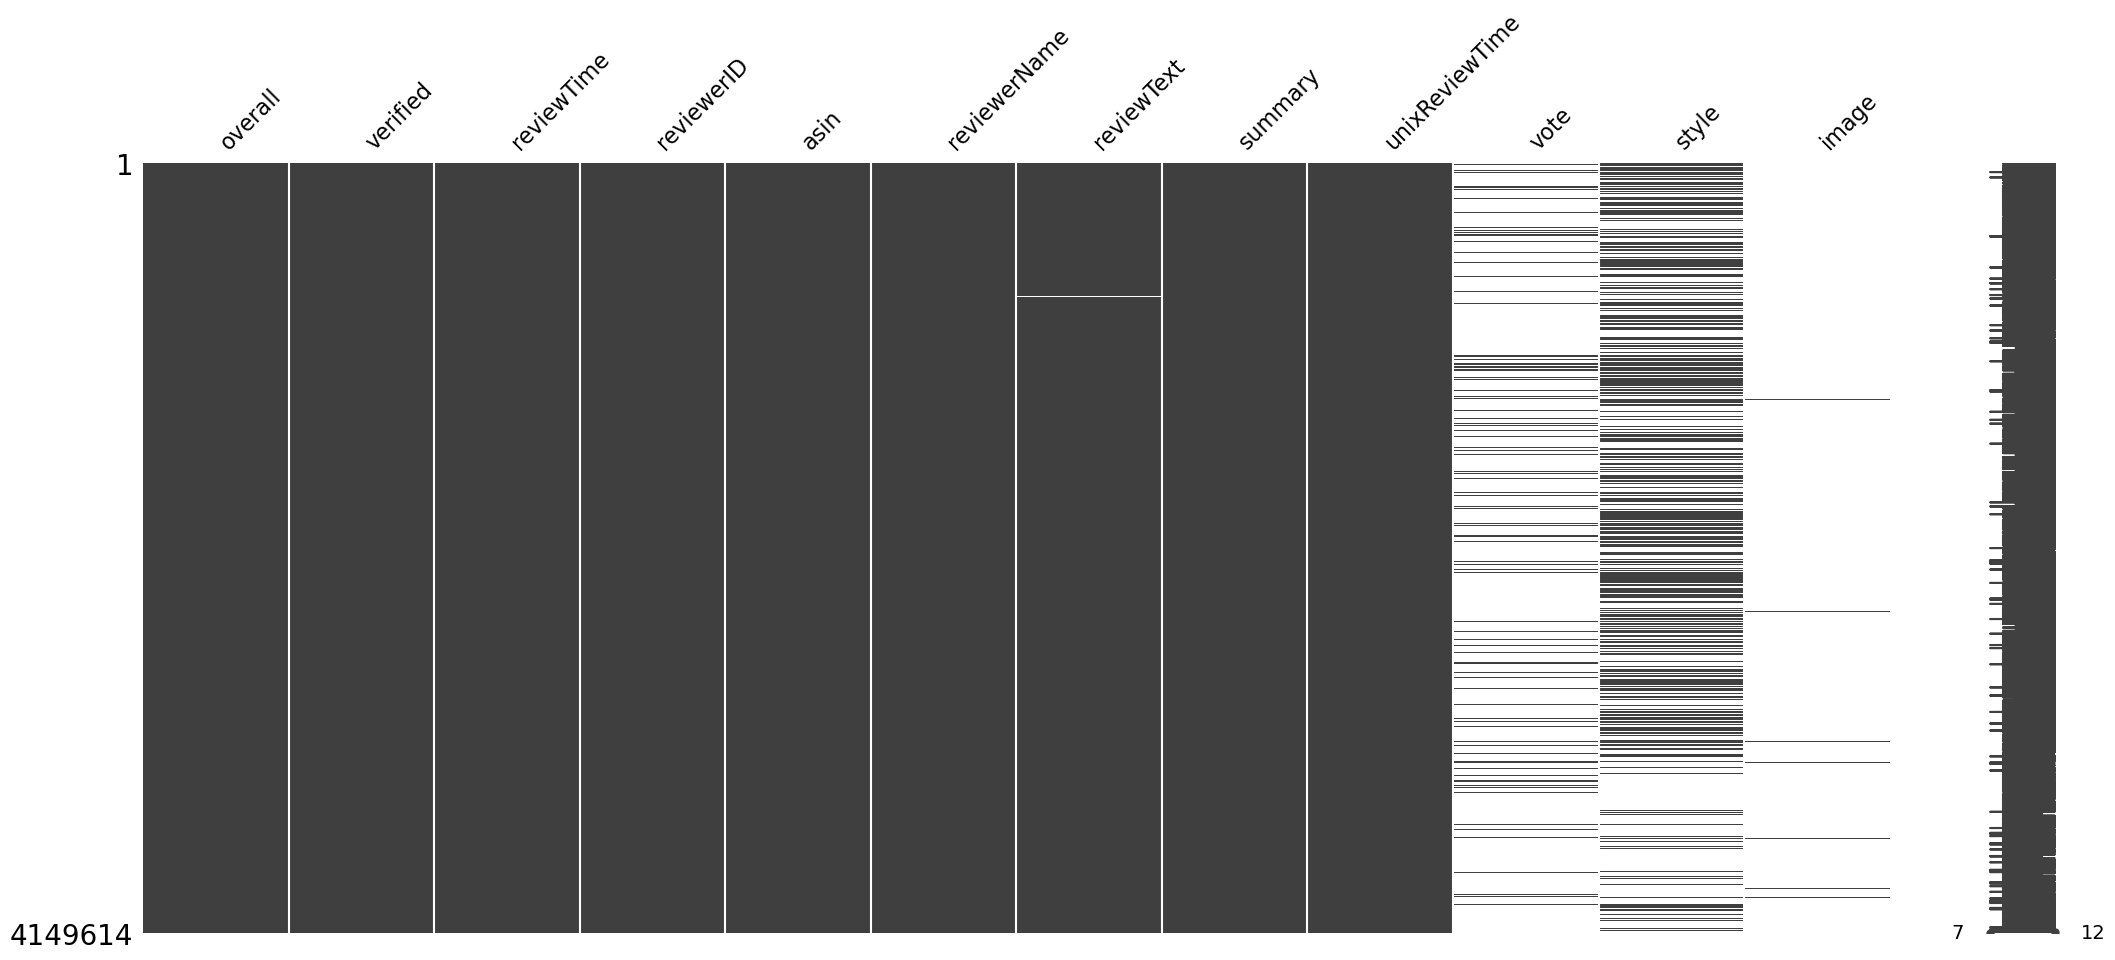

In [134]:
missingno.matrix(reviews_df)

In [135]:
# add the title
reviews_df['title'] = reviews_df['asin'].map(lambda d: asin_title_map[d]['title'])
reviews_df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,1448064000,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,1439337600,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,1432771200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999712,5.0,True,"05 10, 2015",A3J79M83B391JO,B00U648FRU,Champlin-Ritter,Came in great condition. Love this tea the price was right and will order again,Very happy,1431216000,NaN,NaN,NaN,Tong Tji Kaffir Lime Tea
4999713,5.0,True,"02 13, 2017",A2JKN8Q4466GHN,B0091931KW,cheryl young,always a pleasure and always as promised,Five Stars,1486944000,NaN,NaN,NaN,Torani Sauce - SUGAR FREE - Chocolate
4999751,5.0,False,"03 23, 2015",A1TXC0JN8LY768,B00U32D65G,DW,I love the garlic flavor! The chipotle adds some spice and basil is refreshing!,Five Stars,1427068800,NaN,{'Flavor:': ' Basil'},NaN,AVOCARE Extra Virgin Avocado Oil (Basil)
4999753,5.0,True,"05 2, 2017",AD6C3F0DNSMSP,B00TA0FMZY,Amazon Customer,Excellent!!,Great product!!!,1493683200,NaN,NaN,NaN,Coppa Dry Cured Whole Pork Shoulder 2 Lbs


In [136]:
reviews_df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          774
reviewText           2082
summary               988
unixReviewTime          0
vote              3627759
style             2320148
image             4103228
title                   8
dtype: int64

In [137]:
# Drop entries missing review text or title
reviews_df = reviews_df.dropna(subset=['reviewText','title'])
reviews_df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,1448064000,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,1439337600,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,1432771200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999712,5.0,True,"05 10, 2015",A3J79M83B391JO,B00U648FRU,Champlin-Ritter,Came in great condition. Love this tea the price was right and will order again,Very happy,1431216000,NaN,NaN,NaN,Tong Tji Kaffir Lime Tea
4999713,5.0,True,"02 13, 2017",A2JKN8Q4466GHN,B0091931KW,cheryl young,always a pleasure and always as promised,Five Stars,1486944000,NaN,NaN,NaN,Torani Sauce - SUGAR FREE - Chocolate
4999751,5.0,False,"03 23, 2015",A1TXC0JN8LY768,B00U32D65G,DW,I love the garlic flavor! The chipotle adds some spice and basil is refreshing!,Five Stars,1427068800,NaN,{'Flavor:': ' Basil'},NaN,AVOCARE Extra Virgin Avocado Oil (Basil)
4999753,5.0,True,"05 2, 2017",AD6C3F0DNSMSP,B00TA0FMZY,Amazon Customer,Excellent!!,Great product!!!,1493683200,NaN,NaN,NaN,Coppa Dry Cured Whole Pork Shoulder 2 Lbs


In [138]:
import datetime as dt

date_fmt = "%m %d, %Y"
today = dt.date.today()
today.strftime(date_fmt)

'08 07, 2024'

In [139]:
%%time
reviews_df['date']= pd.to_datetime(reviews_df['reviewTime'], infer_datetime_format=False, format=date_fmt)
reviews_df.head()

CPU times: user 4.82 s, sys: 66.2 ms, total: 4.89 s
Wall time: 4.9 s


<timed exec>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title,date
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2014-11-19
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2016-10-13
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,1448064000,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2015-11-21
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,1439337600,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2015-08-12
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,1432771200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2015-05-28


In [140]:
reviews_df['year'] = reviews_df['date'].dt.year

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_85905/2611131130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['year'] = reviews_df['date'].dt.year


<Axes: >

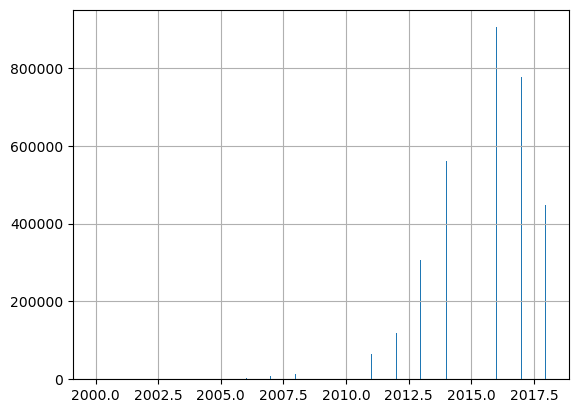

In [141]:
reviews_df['year'].hist(bins='auto')

#### Reducing Review Filesize

<Axes: >

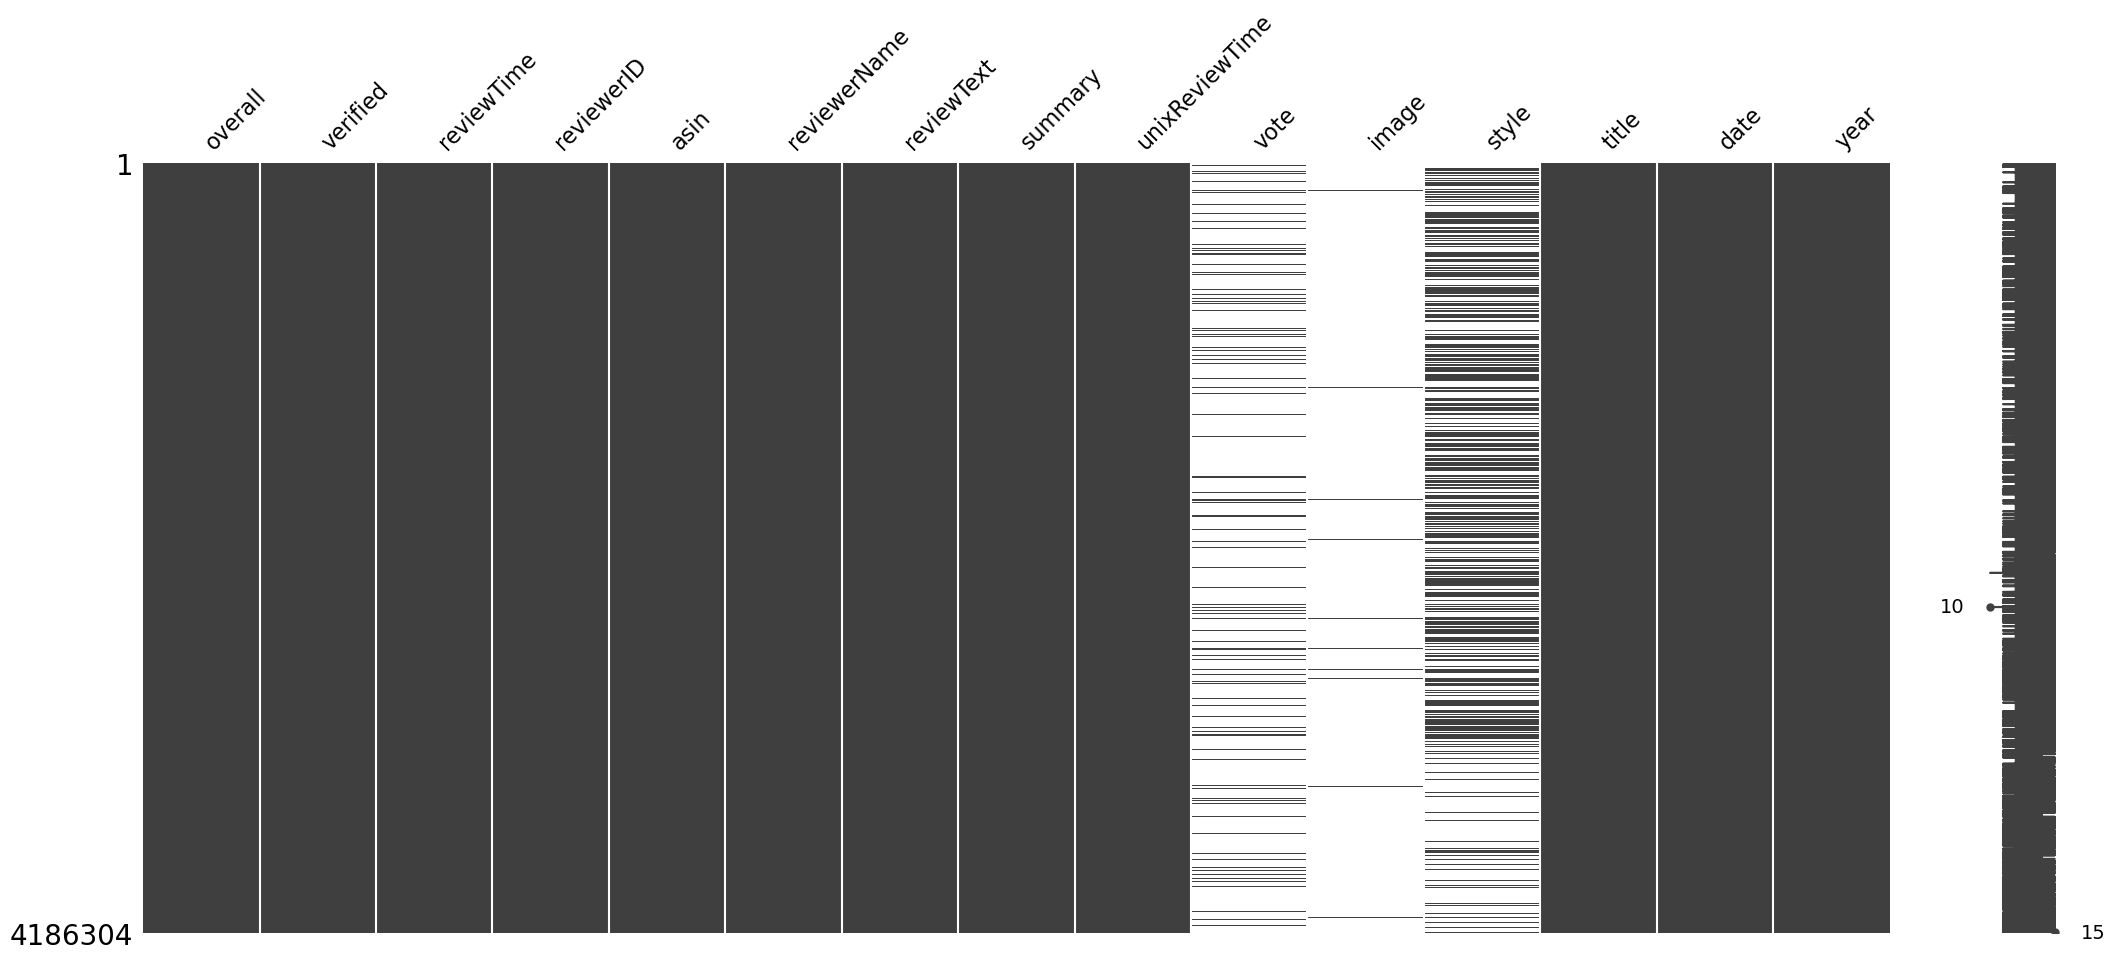

In [251]:
missingno.matrix(reviews_df)

In [252]:
reviews_df['vote'] = reviews_df['vote'].str.replace(",",'')

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_59302/436724679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['vote'] = reviews_df['vote'].str.replace(",",'')


In [253]:
reviews_df['verified'].value_counts()

True     3650974
False     535330
Name: verified, dtype: int64

Keep only verified purchases.

In [142]:
reviews_df = reviews_df[reviews_df['verified']==True]
reviews_df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title,date,year
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2014-11-19,2014
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2016-10-13,2016
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,1448064000,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2015-11-21,2015
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,1439337600,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2015-08-12,2015
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,1432771200,NaN,NaN,NaN,Lipton Yellow Label Finest Blend Tea Bags 100 tea bags Pack of 2 (2 x 7 ox / 2 x 200 g),2015-05-28,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999707,5.0,True,"01 23, 2017",AMZ6B54X7JUDW,B00EGIDOUU,Amazon Customer,taste great!,Five Stars,1485129600,NaN,NaN,NaN,"Starbucks Pike Place Roast Medium Keurig K-cups,10 Count.",2017-01-23,2017
4999712,5.0,True,"05 10, 2015",A3J79M83B391JO,B00U648FRU,Champlin-Ritter,Came in great condition. Love this tea the price was right and will order again,Very happy,1431216000,NaN,NaN,NaN,Tong Tji Kaffir Lime Tea,2015-05-10,2015
4999713,5.0,True,"02 13, 2017",A2JKN8Q4466GHN,B0091931KW,cheryl young,always a pleasure and always as promised,Five Stars,1486944000,NaN,NaN,NaN,Torani Sauce - SUGAR FREE - Chocolate,2017-02-13,2017
4999753,5.0,True,"05 2, 2017",AD6C3F0DNSMSP,B00TA0FMZY,Amazon Customer,Excellent!!,Great product!!!,1493683200,NaN,NaN,NaN,Coppa Dry Cured Whole Pork Shoulder 2 Lbs,2017-05-02,2017


In [143]:
reviews_df['vote'].value_counts()#.head(20)

vote
2.0      92382
2        82485
3.0      41981
3        40609
4        23193
         ...  
215          1
517          1
391          1
379          1
209.0        1
Name: count, Length: 620, dtype: int64

In [144]:
# reviews_df['vote'] = pd.to_numeric(reviews_df['vote'],downcast='integer')
# reviews_df['vote'].value_counts().head(20)

In [145]:
reviews_df.memory_usage().sum()

424059948

In [146]:
# Selecting Final Set of columns and previewing memory usage
keep_cols = ['asin','reviewerID','reviewText','summary',#'date',#'vote',
             'overall','year']
reviews_df[keep_cols].memory_usage().sum()

188471088

In [147]:
# Filtering for final reviews data
reviews_df_final = reviews_df.loc[:, keep_cols]
reviews_df_final

,asin,reviewerID,reviewText,summary,overall,year
0,4639725183,A1QVBUH9E1V6I8,No adverse comment.,Five Stars,5.0,2014
1,4639725183,A3GEOILWLK86XM,Gift for college student.,Great product.,5.0,2016
2,4639725183,A32RD6L701BIGP,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,5.0,2015
3,4639725183,A2UY1O1FBGKIE6,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,5.0,2015
4,4639725183,A3QHVBQYDV7Z6U,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,5.0,2015
...,...,...,...,...,...,...
4999707,B00EGIDOUU,AMZ6B54X7JUDW,taste great!,Five Stars,5.0,2017
4999712,B00U648FRU,A3J79M83B391JO,Came in great condition. Love this tea the price was right and will order again,Very happy,5.0,2015
4999713,B0091931KW,A2JKN8Q4466GHN,always a pleasure and always as promised,Five Stars,5.0,2017
4999753,B00TA0FMZY,AD6C3F0DNSMSP,Excellent!!,Great product!!!,5.0,2017


In [148]:
reviews_df_final.isna().sum()

asin            0
reviewerID      0
reviewText      0
summary       795
overall         0
year            0
dtype: int64

In [149]:
reviews_df_final = reviews_df_final.dropna(subset=['summary','reviewText'])
reviews_df_final

,asin,reviewerID,reviewText,summary,overall,year
0,4639725183,A1QVBUH9E1V6I8,No adverse comment.,Five Stars,5.0,2014
1,4639725183,A3GEOILWLK86XM,Gift for college student.,Great product.,5.0,2016
2,4639725183,A32RD6L701BIGP,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,5.0,2015
3,4639725183,A2UY1O1FBGKIE6,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,5.0,2015
4,4639725183,A3QHVBQYDV7Z6U,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,5.0,2015
...,...,...,...,...,...,...
4999707,B00EGIDOUU,AMZ6B54X7JUDW,taste great!,Five Stars,5.0,2017
4999712,B00U648FRU,A3J79M83B391JO,Came in great condition. Love this tea the price was right and will order again,Very happy,5.0,2015
4999713,B0091931KW,A2JKN8Q4466GHN,always a pleasure and always as promised,Five Stars,5.0,2017
4999753,B00TA0FMZY,AD6C3F0DNSMSP,Excellent!!,Great product!!!,5.0,2017


In [150]:
filter_duplicates = reviews_df_final.duplicated(subset=['reviewerID','asin','reviewText'], keep=False)
filter_duplicates.sum()

1218022

In [151]:
# filter_duplicates = reviews_df_final.duplicated(keep=False)#
reviews_df_final[filter_duplicates].sort_values(["reviewerID",'asin']).head(10)

,asin,reviewerID,reviewText,summary,overall,year
402831,B002UGMH9Y,A0096681Y127OL1H8W3U,sugar of choice,Five Stars,5.0,2015
1297002,B002UGMH9Y,A0096681Y127OL1H8W3U,sugar of choice,Five Stars,5.0,2015
570023,B006RNQ7YW,A0096681Y127OL1H8W3U,best i have everyused,Five Stars,5.0,2015
1929450,B006RNQ7YW,A0096681Y127OL1H8W3U,best i have everyused,Five Stars,5.0,2015
874263,B00OEXP0UE,A0205727NVAUDXS07YYO,Just love these. Excellent flavor and not overly salty.,Five Stars,5.0,2017
3137469,B00OEXP0UE,A0205727NVAUDXS07YYO,Just love these. Excellent flavor and not overly salty.,Five Stars,5.0,2017
194446,B000ZM6BME,A0261431Y0V4MHWY4B7W,"This is where you need to start if you want quick results, the higher the rating the more active agents are avaliable to your system. The taste is strong but great in coffee to replace your sweete...",Amazing Honey at any cost.,5.0,2014
248147,B000ZM6BME,A0261431Y0V4MHWY4B7W,"This is where you need to start if you want quick results, the higher the rating the more active agents are avaliable to your system. The taste is strong but great in coffee to replace your sweete...",Amazing Honey at any cost.,5.0,2014
356154,B001R95CLK,A0261431Y0V4MHWY4B7W,Great base oil for mixing essential oils.,Carrier oil,5.0,2014
1129651,B001R95CLK,A0261431Y0V4MHWY4B7W,Great base oil for mixing essential oils.,Carrier oil,5.0,2014


In [152]:
reviews_df_final = reviews_df_final.drop_duplicates(subset=['asin','reviewerID','reviewText'])
reviews_df_final

,asin,reviewerID,reviewText,summary,overall,year
0,4639725183,A1QVBUH9E1V6I8,No adverse comment.,Five Stars,5.0,2014
1,4639725183,A3GEOILWLK86XM,Gift for college student.,Great product.,5.0,2016
2,4639725183,A32RD6L701BIGP,"If you like strong tea, this is for you. It might even be a little too strong for me.",Strong,5.0,2015
3,4639725183,A2UY1O1FBGKIE6,Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.,Great tea,5.0,2015
4,4639725183,A3QHVBQYDV7Z6U,"I have searched everywhere until I browsed Amazon and found it! This is the tea Lipton should be selling on grocery store shelves. The stuff I last purchased is just awful, and nowhere near as g...",This is the tea I remembered!,5.0,2015
...,...,...,...,...,...,...
4999707,B00EGIDOUU,AMZ6B54X7JUDW,taste great!,Five Stars,5.0,2017
4999712,B00U648FRU,A3J79M83B391JO,Came in great condition. Love this tea the price was right and will order again,Very happy,5.0,2015
4999713,B0091931KW,A2JKN8Q4466GHN,always a pleasure and always as promised,Five Stars,5.0,2017
4999753,B00TA0FMZY,AD6C3F0DNSMSP,Excellent!!,Great product!!!,5.0,2017


In [153]:
os.makedirs('temp', exist_ok=True)

In [154]:
fpath_temp = 'temp/reviews-df-final.csv.gz'
reviews_df_final.to_csv(fpath_temp,compression='gzip', index=False)


In [155]:
s3.upload_file(fpath_temp, bucket_name, fpath_temp.replace("temp/",""))

#### Downcast Data Types

In [156]:
# list bucket files
response = s3.list_objects_v2(Bucket=bucket_name)
for obj in response['Contents']:
    print(f"  - {obj['Key']}")

  - Grocery_and_Gourmet_Food_5.json.gz
  - amazon-metadata-groceries-combined.csv.gz
  - meta_Grocery_and_Gourmet_Food.json.gz
  - reviews-df-final.csv.gz


In [157]:
reviews_df_final.memory_usage().sum()

156659256

In [158]:
reviews_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3012678 entries, 0 to 4999774
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   asin        object 
 1   reviewerID  object 
 2   reviewText  object 
 3   summary     object 
 4   overall     float64
 5   year        int32  
dtypes: float64(1), int32(1), object(4)
memory usage: 149.4+ MB


In [159]:
reviews_df_final['overall'] = reviews_df_final['overall'].astype("float16") 
# reviews_df_final['year'] = reviews_df_final['overall'].astype("int16") 
reviews_df_final.dtypes

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_85905/294472945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df_final['overall'] = reviews_df_final['overall'].astype("float16")


asin           object
reviewerID     object
reviewText     object
summary        object
overall       float16
year            int32
dtype: object

In [160]:
reviews_df_final.memory_usage()#.sum()

Index         24101424
asin          24101424
reviewerID    24101424
reviewText    24101424
summary       24101424
overall        6025356
year          12050712
dtype: int64

In [161]:
# reviews_df_final['date'].astype('datetime32[]').memory_usage()

In [162]:
# reviews_df_final = reviews_df_final.reset_index(drop=True)

## Splitting Final Reviews into Multiple Files (years)

In [163]:
folder_reviews = FPATHS['data']['cleaned']['reviews-by-years_dict']['dir']
folder_reviews

'data/reviews-by-year/'

In [164]:
# Create new folder for reviews by eyars
# folder_reviews = "reviews-by-year/"
os.makedirs(folder_reviews, exist_ok=True)

In [165]:
reviews_df_final['year'].value_counts()

year
2016    663824
2015    641932
2017    590971
2014    379017
2018    365035
2013    215869
2012     73900
2011     38678
2010     20462
2009     11911
2008      5822
2007      4241
2006       917
2005        76
2004        17
2003         4
2002         2
Name: count, dtype: int64

In [166]:
reviews_df_final.dtypes

asin           object
reviewerID     object
reviewText     object
summary        object
overall       float16
year            int32
dtype: object

In [167]:
# loop through year column to filter and save to separate csv
for year in reviews_df_final['year'].unique():
    temp_df = reviews_df_final[reviews_df_final['year'] == year]
    fpath_reviews_part = f'{folder_reviews}amazon-reviews-groceries-gourmet-{year}.csv.gz'
    print(f"- Creating file: {fpath_reviews_part}")

    temp_df.to_csv(fpath_reviews_part, compression={'method': 'gzip', 'compresslevel': 9},
                        index=False)


- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2014.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2016.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2015.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2012.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2008.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2017.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2013.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2011.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2009.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2018.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2002.csv.gz
- Creating file: data/reviews-by-year/amazon-reviews-groceries-gourmet-2010.csv.gz
- Cr

In [168]:
q = folder_reviews = FPATHS['data']['cleaned']['reviews-by-years_dict']['glob']
sorted(glob.glob(q))

['data/reviews-by-year/amazon-reviews-groceries-gourmet-2002.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2003.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2004.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2005.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2006.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2007.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2008.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2009.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2010.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2011.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2012.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2013.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2014.csv.gz',
 'data/reviews-by-year/amazon-reviews-groceries-gourmet-2015.csv.gz',
 'data/reviews-by-ye

> Now move on to notebook 2 for selecting the finals subset of reviews for analysis.

# APPENDIX

In [ ]:
raise Exception("end of current code")

In [ ]:
reviews_df_final

In [ ]:
# reviews_df_final.duplicated(subset=['reviewerID','asin','reviewText']).sum()
# reviews_df_final = 

In [ ]:
# reviews_df_final_a = reviews_df_final[filter_year]
# reviews_df_final_a

In [ ]:
# reviews_df_final_b = reviews_df_final[~filter_year]
# reviews_df_final_b

In [ ]:
# fpath_reviews_a = 'combined-reviews-amazon-groceries-gourmet-pre-2016.csv.gz'
# reviews_df_final_a.to_csv(fpath_reviews_a, compression={'method': 'gzip', 'compresslevel': 9},#compression='gzip', 
#                         index=False)

In [ ]:
# # reviews_df_final.to_excel('combined-reviews-amazon-groceries-gourmet.xlsx', index=False, )
# fpath_reviews_feather = 'combined-reviews-amazon-groceries-gourmet.feather'
# reviews_df_final.reset_index(drop=True).to_feather(fpath_reviews_feather, compression_level=9, chunksize=10_000)

In [ ]:
# fpath_reviews_b = 'combined-reviews-amazon-groceries-gourmet-2016-end.csv.gz'
# reviews_df_final_b.to_csv(fpath_reviews_b, compression={'method': 'gzip', 'compresslevel': 9},#compression='gzip', 
#                         index=False)

> Final reviews  file is still too large

In [ ]:
# # Curious how many reviews per reviewer
# reviewer_counts = reviews_df_final['reviewerID'].value_counts()
# reviewer_counts.hist(bins='auto')

In [ ]:
# reviewer_counts.describe().round(2)

In [ ]:
# # What % of the reviewers in the daataset has more than 10 reviews?
# filter_many_reviews = reviewer_counts>10
# filter_many_reviews.sum()/len(reviewer_counts) * 100

In [ ]:
# many_reviews_id = reviewer_counts[filter_many_reviews].index
# len(many_reviews_id)

In [ ]:
# reviews_df_final[reviews_df_final['reviewerID'].isin(many_reviews_id)]